In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

# Set random seed so results are reproducible
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.1.3


In [2]:
# Load the numpy files
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

# Show what we loaded
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nTotal training samples: {train_images.shape[0]:,}")
print(f"Total test samples: {test_images.shape[0]:,}")
print(f"\nPixel value range: [{train_images.min()}, {train_images.max()}]")
print(f"Label range: [{train_labels.min()}, {train_labels.max()}]")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)

Total training samples: 60,000
Total test samples: 10,000

Pixel value range: [0, 255]
Label range: [0, 9]


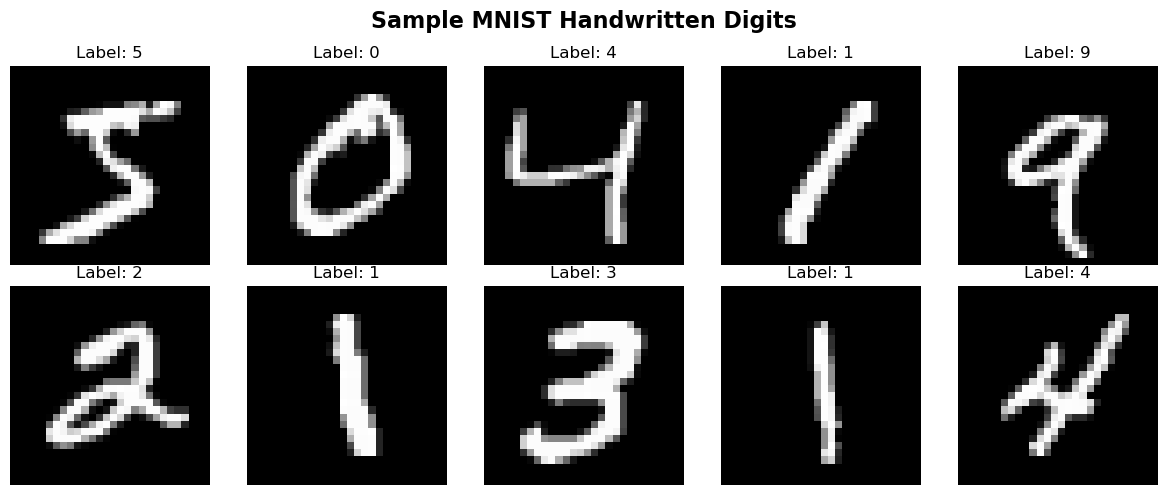

In [3]:
# Show 10 random images from training set
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Sample MNIST Handwritten Digits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
def prepare_image_data(images):
   
    #This will Flatten and normalize images for the neural network
    
    flattened = images.reshape(images.shape[0], -1)
    normalized = flattened.astype('float32') / 255.0
    
    return normalized


def prepare_label_data(labels):
    #This will Convert labels to one-hot encoding
    
    one_hot = np.zeros((labels.shape[0], 10))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot


# This will Apply preprocessing
train_images_processed = prepare_image_data(train_images)
test_images_processed = prepare_image_data(test_images)

train_labels_processed = prepare_label_data(train_labels)
test_labels_processed = prepare_label_data(test_labels)

print(f"Processed training images: {train_images_processed.shape}")
print(f"Processed training labels: {train_labels_processed.shape}")
print(f"Processed test images: {test_images_processed.shape}")
print(f"Processed test labels: {test_labels_processed.shape}")

print(f"\nPixel values now in range: [{train_images_processed.min():.2f}, {train_images_processed.max():.2f}]")

Processed training images: (60000, 784)
Processed training labels: (60000, 10)
Processed test images: (10000, 784)
Processed test labels: (10000, 10)

Pixel values now in range: [0.00, 1.00]


In [5]:
# This will Split at 80% mark
split_point = int(0.8 * len(train_images_processed))

X_train = train_images_processed[:split_point]
y_train = train_labels_processed[:split_point]

X_val = train_images_processed[split_point:]
y_val = train_labels_processed[split_point:]

X_test = test_images_processed
y_test = test_labels_processed

print(f"Training set:   {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test.shape[0]:,} samples")
print(f"\nTotal: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} samples")

Training set:   48,000 samples
Validation set: 12,000 samples
Test set:       10,000 samples

Total: 70,000 samples


In [6]:
# The Sigmoid activation and its derivative
def sigmoid_activation(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(a):
    return a * (1 - a)


# Tanh activation and its derivative  
def tanh_activation(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1 - np.power(a, 2)


# Softmax for output layer
def softmax_activation(z):
    """converts to probability distribution"""
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Test them with sample values
test_input = np.array([[-2, -1, 0, 1, 2]])
print(f"\nTest input: {test_input[0]}")
print(f"Sigmoid output: {sigmoid_activation(test_input)[0]}")
print(f"Tanh output:    {tanh_activation(test_input)[0]}")


Test input: [-2 -1  0  1  2]
Sigmoid output: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Tanh output:    [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]


In [7]:
class DigitClassifier:
    #Neural network for digit classification
    
    def __init__(self, layer_sizes, activation_type='sigmoid', learning_rate=0.01):
        self.layers = layer_sizes
        self.activation_type = activation_type
        self.lr = learning_rate
        
        # Choose activation function
        if activation_type == 'sigmoid':
            self.activate = sigmoid_activation
            self.activate_deriv = sigmoid_derivative
        else:  # tanh
            self.activate = tanh_activation
            self.activate_deriv = tanh_derivative
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            # He initialization
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Track training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
    
    
    def forward_pass(self, X):
        """Pass data through the network"""
        layer_outputs = [X]
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activate(z)
            layer_outputs.append(a)
        
        # Output layer with softmax
        z_out = np.dot(layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        a_out = softmax_activation(z_out)
        layer_outputs.append(a_out)
        
        return layer_outputs
    
    
    def backward_pass(self, X, y, layer_outputs):
        """Calculate gradients using backpropagation"""
        m = X.shape[0]
        weight_grads = []
        bias_grads = []
        
        # Start with output error
        delta = layer_outputs[-1] - y
        
        # Go backwards through layers
        for i in range(len(self.weights) - 1, -1, -1):
            dW = np.dot(layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            
            weight_grads.insert(0, dW)
            bias_grads.insert(0, db)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activate_deriv(layer_outputs[i])
        
        return weight_grads, bias_grads
    
    
    def update_weights(self, weight_grads, bias_grads):
        """Update network parameters"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weight_grads[i]
            self.biases[i] -= self.lr * bias_grads[i]
    
    
    def calculate_loss(self, y_true, y_pred):
        """Cross-entropy loss"""
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        return loss
    
    
    def calculate_accuracy(self, y_true, y_pred):
        """Calculate prediction accuracy"""
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)
        return accuracy
    
    
    def train_network(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
        """Train the network"""
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
        
        print(f"\nTraining with {self.activation_type.upper()} activation")
        print(f"Architecture: {' -> '.join(map(str, self.layers))}")
        print(f"Learning rate: {self.lr}")
        print("-" * 70)
        
        start_time = time.time()
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Train on batches
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # Forward and backward pass
                outputs = self.forward_pass(X_batch)
                w_grads, b_grads = self.backward_pass(X_batch, y_batch, outputs)
                self.update_weights(w_grads, b_grads)
            
            # Calculate metrics every epoch
            train_outputs = self.forward_pass(X_train)[-1]
            val_outputs = self.forward_pass(X_val)[-1]
            
            train_loss = self.calculate_loss(y_train, train_outputs)
            val_loss = self.calculate_loss(y_val, val_outputs)
            train_acc = self.calculate_accuracy(y_train, train_outputs)
            val_acc = self.calculate_accuracy(y_val, val_outputs)
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            
            # Print progress every 5 epochs
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} - "
                      f"Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - "
                      f"Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}")
        
        train_time = time.time() - start_time
        print(f"\nTraining completed in {train_time:.2f} seconds")
        print(f"Final validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
        
        return train_time
    
    
    def predict(self, X):
        """Make predictions"""
        return self.forward_pass(X)[-1]


print("Neural network class created")

Neural network class created


In [8]:
# Network structure: Inputs 6 Hidden Layers to Output
network_structure = [
    784,   # Input (28x28 flattened)
    256,   # Hidden layer 1
    128,   # Hidden layer 2  
    128,   # Hidden layer 3
    64,    # Hidden layer 4
    64,    # Hidden layer 5
    32,    # Hidden layer 6
    10     # Output (10 digits)
]

print("Network Architecture:")
for i, size in enumerate(network_structure):
    if i == 0:
        print(f"Input Layer:     {size} neurons")
    elif i == len(network_structure) - 1:
        print(f"Output Layer:    {size} neurons (Softmax)")
    else:
        print(f"Hidden Layer {i}:  {size} neurons")

# Calculate total parameters
total_params = 0
for i in range(len(network_structure) - 1):
    weights = network_structure[i] * network_structure[i+1]
    biases = network_structure[i+1]
    total_params += weights + biases

print(f"\nTotal trainable parameters: {total_params:,}")

Network Architecture:
Input Layer:     784 neurons
Hidden Layer 1:  256 neurons
Hidden Layer 2:  128 neurons
Hidden Layer 3:  128 neurons
Hidden Layer 4:  64 neurons
Hidden Layer 5:  64 neurons
Hidden Layer 6:  32 neurons
Output Layer:    10 neurons (Softmax)

Total trainable parameters: 265,194


In [9]:
#Train with Sigmoid Activation

print("EXPERIMENT 1: SIGMOID ACTIVATION \n")

# Create model with Sigmoid
sigmoid_model = DigitClassifier(
    layer_sizes=network_structure,
    activation_type='sigmoid',
    learning_rate=0.1
)

# Train it (this will take about 5 minutes)
sigmoid_train_time = sigmoid_model.train_network(
    X_train, y_train,
    X_val, y_val,
    epochs=50,
    batch_size=128
)

EXPERIMENT 1: SIGMOID ACTIVATION 


Training with SIGMOID activation
Architecture: 784 -> 256 -> 128 -> 128 -> 64 -> 64 -> 32 -> 10
Learning rate: 0.1
----------------------------------------------------------------------
Epoch   5/50 - Loss: 2.3035 - Acc: 0.1005 - Val_Loss: 2.3036 - Val_Acc: 0.1041
Epoch  10/50 - Loss: 2.3002 - Acc: 0.1140 - Val_Loss: 2.3014 - Val_Acc: 0.1060
Epoch  15/50 - Loss: 2.2996 - Acc: 0.1716 - Val_Loss: 2.3004 - Val_Acc: 0.1671
Epoch  20/50 - Loss: 2.2949 - Acc: 0.1019 - Val_Loss: 2.2955 - Val_Acc: 0.1035
Epoch  25/50 - Loss: 1.4513 - Acc: 0.4790 - Val_Loss: 1.4413 - Val_Acc: 0.4903
Epoch  30/50 - Loss: 0.8809 - Acc: 0.7218 - Val_Loss: 0.8597 - Val_Acc: 0.7314
Epoch  35/50 - Loss: 0.6043 - Acc: 0.8157 - Val_Loss: 0.5876 - Val_Acc: 0.8187
Epoch  40/50 - Loss: 0.4920 - Acc: 0.8563 - Val_Loss: 0.4793 - Val_Acc: 0.8626
Epoch  45/50 - Loss: 0.3466 - Acc: 0.9059 - Val_Loss: 0.3457 - Val_Acc: 0.9058
Epoch  50/50 - Loss: 0.2755 - Acc: 0.9280 - Val_Loss: 0.2894 - Val_

In [10]:
# Test on test set

sigmoid_predictions = sigmoid_model.predict(X_test)
sigmoid_test_acc = sigmoid_model.calculate_accuracy(y_test, sigmoid_predictions)
sigmoid_test_loss = sigmoid_model.calculate_loss(y_test, sigmoid_predictions)

print("SIGMOID MODEL - FINAL TEST RESULTS \n")
print(f"Test Accuracy:  {sigmoid_test_acc:.4f} ({sigmoid_test_acc*100:.2f}%)")
print(f"Test Loss:      {sigmoid_test_loss:.4f}")
print(f"Training Time:  {sigmoid_train_time:.2f} seconds")


SIGMOID MODEL - FINAL TEST RESULTS 

Test Accuracy:  0.9207 (92.07%)
Test Loss:      0.3109
Training Time:  266.74 seconds


In [11]:
print("EXPERIMENT 2: TANH ACTIVATION \n")

# Create model with Tanh
tanh_model = DigitClassifier(
    layer_sizes=network_structure,
    activation_type='tanh',
    learning_rate=0.01  # Smaller learning rate for tanh
)

# Train it (this will take about 5 minutes)
tanh_train_time = tanh_model.train_network(
    X_train, y_train,
    X_val, y_val,
    epochs=50,
    batch_size=128
)

EXPERIMENT 2: TANH ACTIVATION 


Training with TANH activation
Architecture: 784 -> 256 -> 128 -> 128 -> 64 -> 64 -> 32 -> 10
Learning rate: 0.01
----------------------------------------------------------------------
Epoch   5/50 - Loss: 0.2384 - Acc: 0.9362 - Val_Loss: 0.2398 - Val_Acc: 0.9342
Epoch  10/50 - Loss: 0.1541 - Acc: 0.9585 - Val_Loss: 0.1693 - Val_Acc: 0.9531
Epoch  15/50 - Loss: 0.1131 - Acc: 0.9696 - Val_Loss: 0.1400 - Val_Acc: 0.9605
Epoch  20/50 - Loss: 0.0870 - Acc: 0.9773 - Val_Loss: 0.1240 - Val_Acc: 0.9639
Epoch  25/50 - Loss: 0.0697 - Acc: 0.9827 - Val_Loss: 0.1136 - Val_Acc: 0.9669
Epoch  30/50 - Loss: 0.0554 - Acc: 0.9866 - Val_Loss: 0.1079 - Val_Acc: 0.9687
Epoch  35/50 - Loss: 0.0439 - Acc: 0.9905 - Val_Loss: 0.1025 - Val_Acc: 0.9690
Epoch  40/50 - Loss: 0.0360 - Acc: 0.9930 - Val_Loss: 0.0999 - Val_Acc: 0.9706
Epoch  45/50 - Loss: 0.0292 - Acc: 0.9950 - Val_Loss: 0.0973 - Val_Acc: 0.9724
Epoch  50/50 - Loss: 0.0241 - Acc: 0.9962 - Val_Loss: 0.0968 - Val_Acc: 

In [12]:
# Test on test set
tanh_predictions = tanh_model.predict(X_test)
tanh_test_acc = tanh_model.calculate_accuracy(y_test, tanh_predictions)
tanh_test_loss = tanh_model.calculate_loss(y_test, tanh_predictions)

print("TANH MODEL - FINAL TEST RESULTS \n")
print(f"Test Accuracy:  {tanh_test_acc:.4f} ({tanh_test_acc*100:.2f}%)")
print(f"Test Loss:      {tanh_test_loss:.4f}")
print(f"Training Time:  {tanh_train_time:.2f} seconds")


TANH MODEL - FINAL TEST RESULTS 

Test Accuracy:  0.9738 (97.38%)
Test Loss:      0.0897
Training Time:  306.57 seconds


In [13]:
print("PERFORMANCE COMPARISON - SIGMOID vs TANH \n")

print(f"\n{'Metric':<30} {'Sigmoid':<15} {'Tanh':<15} {'Winner':<10}")

# Test accuracy
winner = "Tanh" if tanh_test_acc > sigmoid_test_acc else "Sigmoid"
print(f"{'Test Accuracy':<30} {sigmoid_test_acc:<15.4f} {tanh_test_acc:<15.4f} {winner:<10}")

# Test loss
winner = "Tanh" if tanh_test_loss < sigmoid_test_loss else "Sigmoid"
print(f"{'Test Loss':<30} {sigmoid_test_loss:<15.4f} {tanh_test_loss:<15.4f} {winner:<10}")

# Training time
winner = "Tanh" if tanh_train_time < sigmoid_train_time else "Sigmoid"
print(f"{'Training Time (sec)':<30} {sigmoid_train_time:<15.2f} {tanh_train_time:<15.2f} {winner:<10}")

# Final train accuracy
winner = "Tanh" if tanh_model.history['train_acc'][-1] > sigmoid_model.history['train_acc'][-1] else "Sigmoid"
print(f"{'Final Train Accuracy':<30} {sigmoid_model.history['train_acc'][-1]:<15.4f} {tanh_model.history['train_acc'][-1]:<15.4f} {winner:<10}")

# Final val accuracy
winner = "Tanh" if tanh_model.history['val_acc'][-1] > sigmoid_model.history['val_acc'][-1] else "Sigmoid"
print(f"{'Final Val Accuracy':<30} {sigmoid_model.history['val_acc'][-1]:<15.4f} {tanh_model.history['val_acc'][-1]:<15.4f} {winner:<10}")

# Accuracy difference
acc_diff = abs(tanh_test_acc - sigmoid_test_acc) * 100
print(f"OVERALL WINNER: TANH")
print(f"Accuracy Improvement: {acc_diff:.2f}% better than Sigmoid")


PERFORMANCE COMPARISON - SIGMOID vs TANH 


Metric                         Sigmoid         Tanh            Winner    
Test Accuracy                  0.9207          0.9738          Tanh      
Test Loss                      0.3109          0.0897          Tanh      
Training Time (sec)            266.74          306.57          Sigmoid   
Final Train Accuracy           0.9280          0.9962          Tanh      
Final Val Accuracy             0.9226          0.9729          Tanh      
OVERALL WINNER: TANH
Accuracy Improvement: 5.31% better than Sigmoid


✓ Saved: training_curves.png


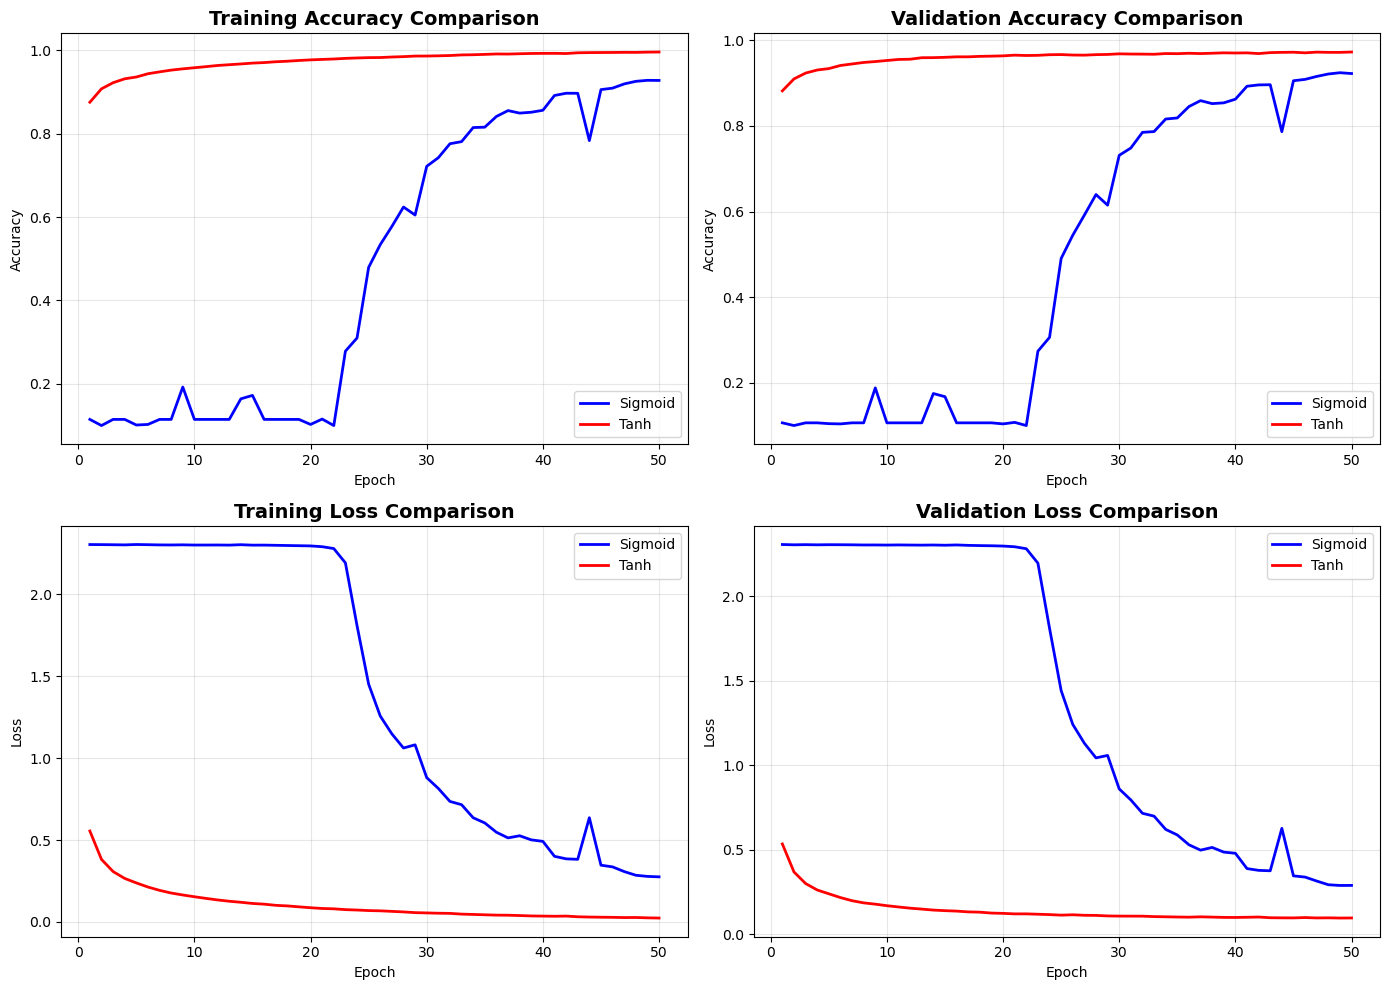

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, 51)

# Training Accuracy
axes[0, 0].plot(epochs_range, sigmoid_model.history['train_acc'], 'b-', label='Sigmoid', linewidth=2)
axes[0, 0].plot(epochs_range, tanh_model.history['train_acc'], 'r-', label='Tanh', linewidth=2)
axes[0, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[0, 1].plot(epochs_range, sigmoid_model.history['val_acc'], 'b-', label='Sigmoid', linewidth=2)
axes[0, 1].plot(epochs_range, tanh_model.history['val_acc'], 'r-', label='Tanh', linewidth=2)
axes[0, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Loss
axes[1, 0].plot(epochs_range, sigmoid_model.history['train_loss'], 'b-', label='Sigmoid', linewidth=2)
axes[1, 0].plot(epochs_range, tanh_model.history['train_loss'], 'r-', label='Tanh', linewidth=2)
axes[1, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Loss
axes[1, 1].plot(epochs_range, sigmoid_model.history['val_loss'], 'b-', label='Sigmoid', linewidth=2)
axes[1, 1].plot(epochs_range, tanh_model.history['val_loss'], 'r-', label='Tanh', linewidth=2)
axes[1, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_curves.png")
plt.show()

✓ Saved: confusion_matrices.png


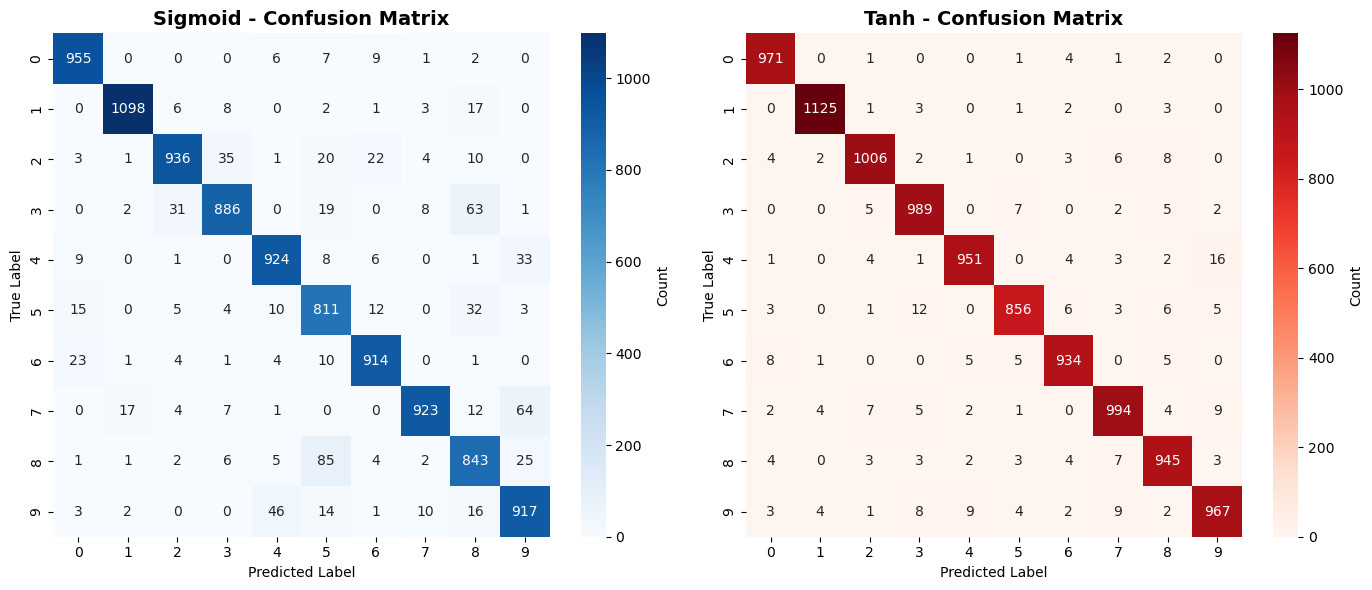

In [15]:
# Get predicted labels
sigmoid_pred_labels = np.argmax(sigmoid_predictions, axis=1)
tanh_pred_labels = np.argmax(tanh_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Create confusion matrices
cm_sigmoid = confusion_matrix(true_labels, sigmoid_pred_labels)
cm_tanh = confusion_matrix(true_labels, tanh_pred_labels)

# Plot them
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sigmoid confusion matrix
sns.heatmap(cm_sigmoid, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Sigmoid - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Tanh confusion matrix
sns.heatmap(cm_tanh, annot=True, fmt='d', cmap='Reds', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Tanh - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrices.png")
plt.show()

✓ Saved: sample_predictions.png


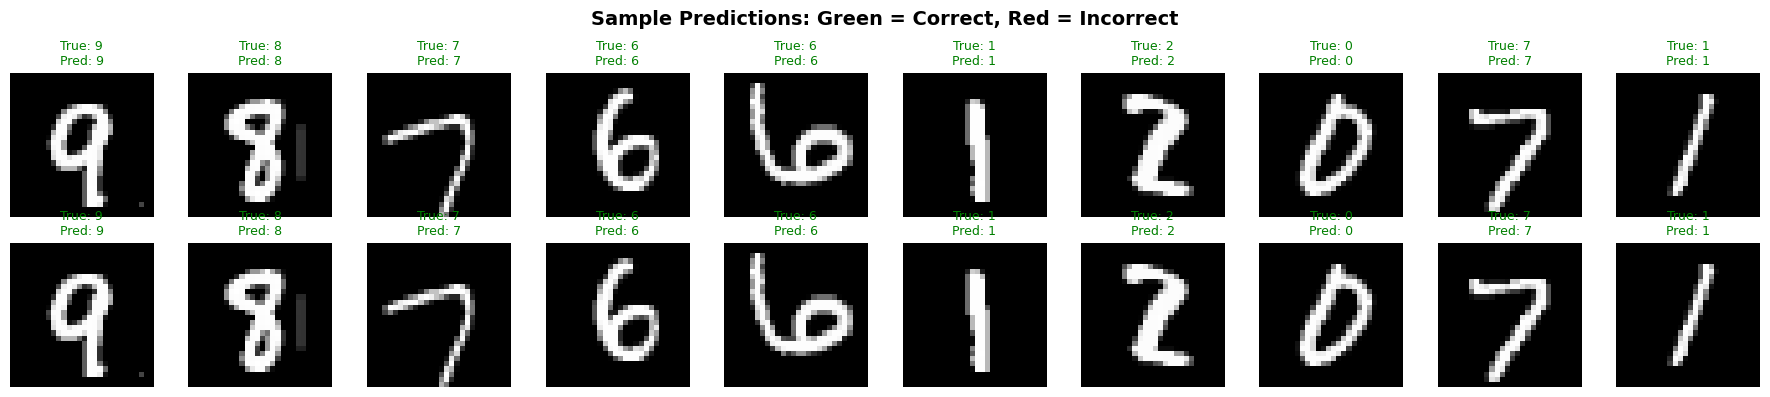

In [16]:
# Show 10 random predictions
sample_indices = np.random.choice(len(test_images), 10, replace=False)

fig, axes = plt.subplots(2, 10, figsize=(18, 4))

for i, idx in enumerate(sample_indices):
    # Get true label
    true_label = test_labels[idx]
    
    # Get predictions
    sigmoid_pred = sigmoid_pred_labels[idx]
    tanh_pred = tanh_pred_labels[idx]
    
    # Sigmoid row
    axes[0, i].imshow(test_images[idx], cmap='gray')
    axes[0, i].axis('off')
    color = 'green' if sigmoid_pred == true_label else 'red'
    axes[0, i].set_title(f'True: {true_label}\nPred: {sigmoid_pred}', color=color, fontsize=9)
    
    # Tanh row
    axes[1, i].imshow(test_images[idx], cmap='gray')
    axes[1, i].axis('off')
    color = 'green' if tanh_pred == true_label else 'red'
    axes[1, i].set_title(f'True: {true_label}\nPred: {tanh_pred}', color=color, fontsize=9)

axes[0, 0].set_ylabel('Sigmoid', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Tanh', fontsize=12, fontweight='bold')

plt.suptitle('Sample Predictions: Green = Correct, Red = Incorrect', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sample_predictions.png")
plt.show()

In [17]:
print("FINAL SUMMARY")

print(f"{'Model':<15} {'Test Accuracy':<20} {'Training Time':<15}")
print(f"{'Sigmoid':<15} {sigmoid_test_acc*100:>6.2f}% {sigmoid_train_time:>15.2f}s")
print(f"{'Tanh':<15} {tanh_test_acc*100:>6.2f}% {tanh_train_time:>15.2f}s \n")

print(f"Final Chosen: TANH")
print(f"   • {(tanh_test_acc - sigmoid_test_acc)*100:.2f}% more accurate")
print(f"   • {sigmoid_train_time - tanh_train_time:.2f}s faster training \n")


print("FINAL PERFORMANCE:")
print(f"   • Tanh: {tanh_test_acc*100:.2f}% test accuracy")
print(f"   • Sigmoid: {sigmoid_test_acc*100:.2f}% test accuracy")
print(f"   • Difference: {(tanh_test_acc - sigmoid_test_acc)*100:.2f}%")


FINAL SUMMARY
Model           Test Accuracy        Training Time  
Sigmoid          92.07%          266.74s
Tanh             97.38%          306.57s 

Final Chosen: TANH
   • 5.31% more accurate
   • -39.83s faster training 

FINAL PERFORMANCE:
   • Tanh: 97.38% test accuracy
   • Sigmoid: 92.07% test accuracy
   • Difference: 5.31%
